# Ejemplo de análisis de series temporales: Consumo diario de energía

- [Fuente de datos](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/): Vamos a utilizar los datos de consumo eléctrico alemán. 

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Load the Data

Si vamos a la fuente de datos original, la serie de datos está desde el 2006, pero nosotros para practicar vamos a ver sólo dos años (2016-2017)

In [3]:
# Lo primero que hacemos es leer nuestra base de datos
# Lo que hace usecols es seleccionar las columnas que queremos, empezando la primera por 0. 

data = pd.read_csv('./data/opsd_germany_daily.csv', usecols=[0,1]) 

# Arreglamos un poco la tabla para poder visualizar mejor que es lo que tenemos
data.Date = pd.to_datetime(data.Date)
consumo = data.copy().set_index(data.Date).drop('Date', axis=1)['2016':]  #set index identifica las columnas como índices
consumo.head()

,Consumption
Date,
2016-01-01,1060.366
2016-01-02,1192.698
2016-01-03,1179.282
2016-01-04,1456.294
2016-01-05,1506.737


# Visualizamos los datos

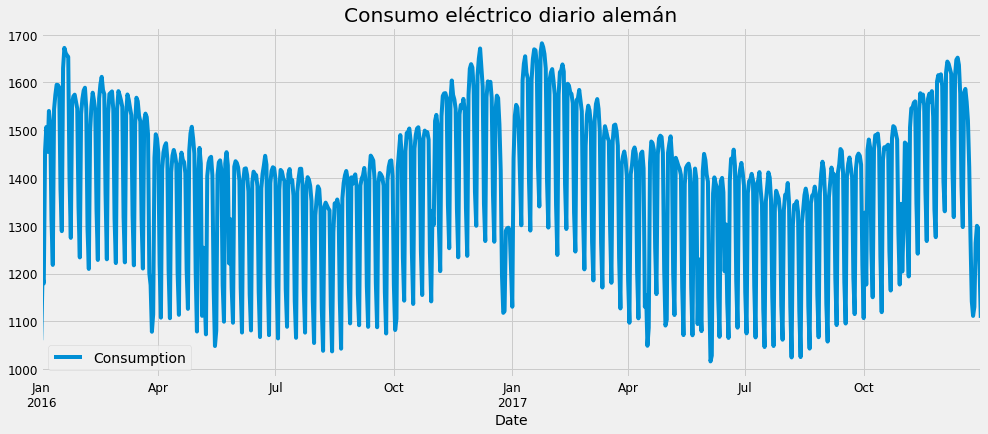

In [5]:

serie = consumo.plot(figsize=(15, 6), title='Consumo eléctrico diario alemán')

# Descomposición de series

Vamos a usar un método de descomposición de series temporales para descomponer nuestra serie en tres componentes: 
- tendencia 
- estacionalidad
- aleatoriedad o ruido

In [5]:
#ys = y.diff().dropna()

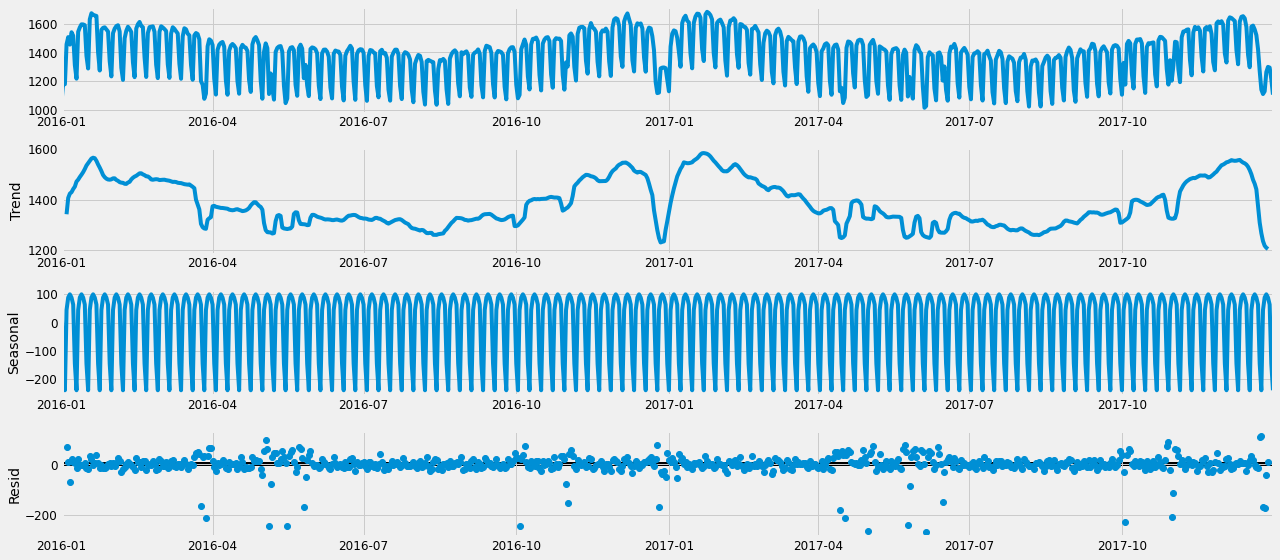

In [6]:
# Una forma visual y simple de hacer esto es utilizar tsa.seasonal_descompose de statsmodel
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(consumo, model='additive')
fig = decomposition.plot()

El gráfico muestra claramente que los datos no son estacionarios.

- Hay una tendencia clara, disminuyendo de enero a julio y aumentando de julio a diciembre. Esto sugiere que tendremos que realizar una diferenciación.
- ¿Hay estacionalidad, bastante consistente a lo largo de los años?.
- El término de ruido parece haber aumentado en algún mes, generalmente entre abril y julio, enero y octubre, es posible que debamos realizar algún tipo de transformación.

# Ajustando nuestra serie temporal utilizando un modelo SARIMA

Podemos usar un método clásico para el análisis de series de tiempo **SARIMA** y cuyas siglas en inglés sería algo así como Promedio Móvil Integrado Auto Regresivo Estacional. 

Los modelos **SARIMA** se escriben **SARIMA(p, d, q, P, D, Q,s)** donde:

- **p** es el orden del componente Auto Regresivo (cómo los consumos pasados afectan el consumo presente)
- **d** es el orden de la diferencia necesaria para eliminar tendencias sistemáticas en los datos
- **q** es el orden del componente Media Móvil (efectos de ruido, lo que no sabemos)
- **P, D, Q** son orden equivalente para los efectos estacionales en el consumo de 
- **s** es equivalente al ciclo de la serie

Entonces la pregunta es ¿cómo determinamos p, d, q, P, D, Q,s?

- ## ¿Podemos determinarlos optimizándolos con Grid Search?
Por supuesto

In [8]:
def grid_search(consumo, pdq, seasonal_pdq):

    warnings.filterwarnings("ignore")
    aic = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:

              # https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
                mod = sm.tsa.statespace.SARIMAX(consumo,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                name = param+param_seasonal
                aic[name] = results.aic
                print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

aic = grid_search(y, pdq, seasonal_pdq)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)


NameError: name 'y' is not defined

In [9]:
# obtener el modelo con mínimo aic: min(dict, key=dict.get) devolverá la clave con valor mínimo en dict
print("Model with Minimum AIC {}".format(min(aic, key=aic.get)))

NameError: name 'aic' is not defined

--- 
Aprendemos de **Grid Search** que el mejor modelo basado en AIC es SARIMA(1,1,1)*(0,1,1,7).
Pero la búsqueda en Grid puede ser tediosa y consumir mucho tiempo. También podemos utilizar otros conceptos como la Función de Autocorrelación (ACF) y la Función de Autocorrelación Parcial (PACF)

---

## Determinar los órdenes usando  ACF and PACF

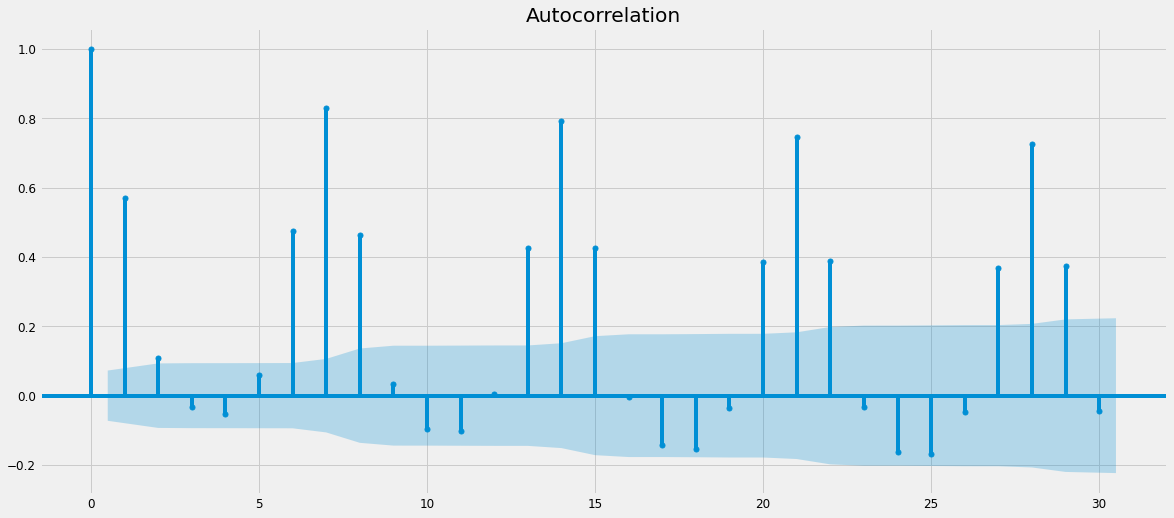

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(consumo, lags=30)
plt.show()

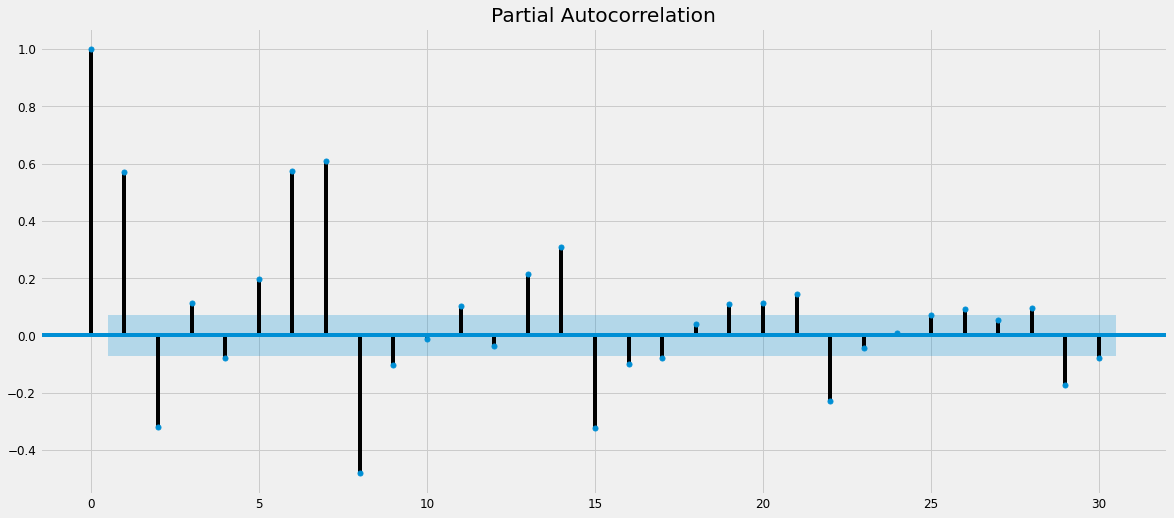

In [18]:
plot_pacf(consumo, lags=30)
plt.show()

**Del gráfico de autocorrelación ACF**

Vemos una estructura de corte, después del retardo 2 (sugiere que los posibles valores de q son 0, 1, 2)
Vemos un efecto repetitivo (estacional) después de 7 días (sugerimos s = 7)

**Del gráfico de autocorrelación parcial ACF**

No está claro si tenemos una estructura de corte, pero vemos uno o dos retrasos/retardos significativos al comienzo de cada período (sugiere que los posibles valores de p son 0, 1, 2)
Vemos un efecto repetitivo (estacional) después de 7 días (sugerimos s = 7)

**¿Cómo determinamos d?**
Bueno, podemos tomar la diferencia de primer orden y ver si eso elimina la tendencia. En este caso lo hace. Como se muestra a continuación, el componente de tendencia es más o menos estacionario.

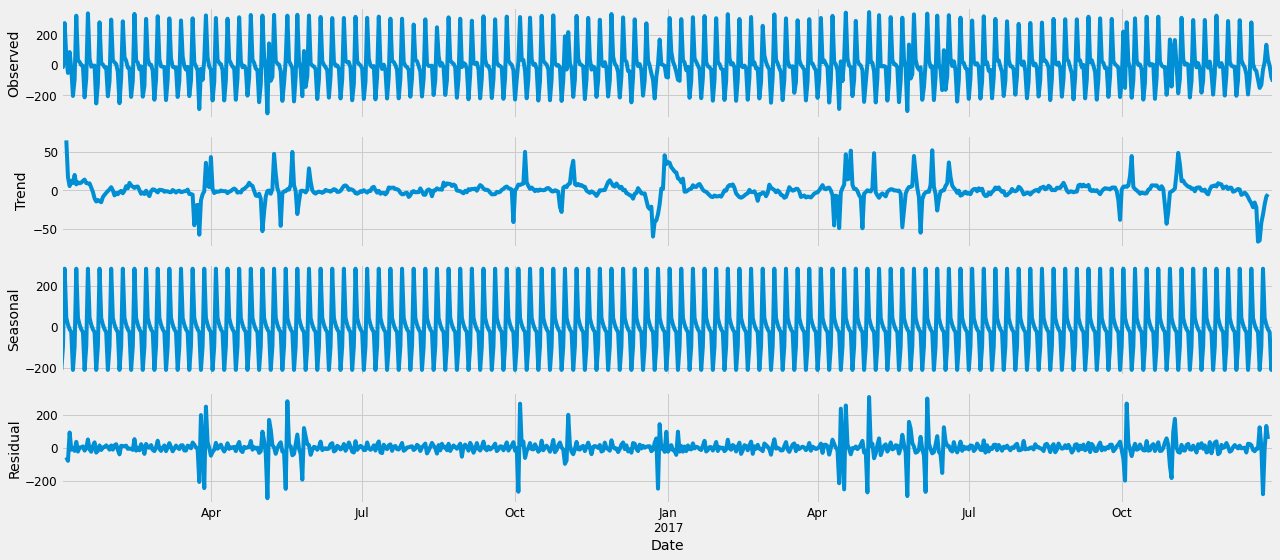

In [19]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(consumo.diff().dropna(), model='additive')
fig = decomposition.plot()

**¿Cómo determinamos P,D,Q?** 
- P: Si el PACF en el lag s vuelve a ser significativo, P corresponde al número de lags significativos en esa zona (a partir de s).
- Q: Si el ACF en el lag s vuelve a ser significativo, Q corresponde al número de  lags significativos en esa zona (a partir de s).


## Ajustando el modelo

In [20]:
# Una vez que hemos obtenido los parámetros, ajustamos el modelo
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4751      0.039     12.240      0.000       0.399       0.551
ma.L1         -0.8244      0.030    -27.112      0.000      -0.884      -0.765
ma.S.L7       -1.0000     12.058     -0.083      0.934     -24.634      22.634
sigma2      2784.5647   3.36e+04      0.083      0.934   -6.31e+04    6.87e+04


El resumen anterior muestra que
- El coeficiente estimado para el componente AR (0.4751) es significativo ya que el valor p es pequeño
- El parámetro estimado para el componente MA es significativo
- La desviación estándar estimada del término de ruido no es significativa. Esto es un problema. Es posible que necesitemos alguna transformación en los datos.

## Diagnóstico del modelo

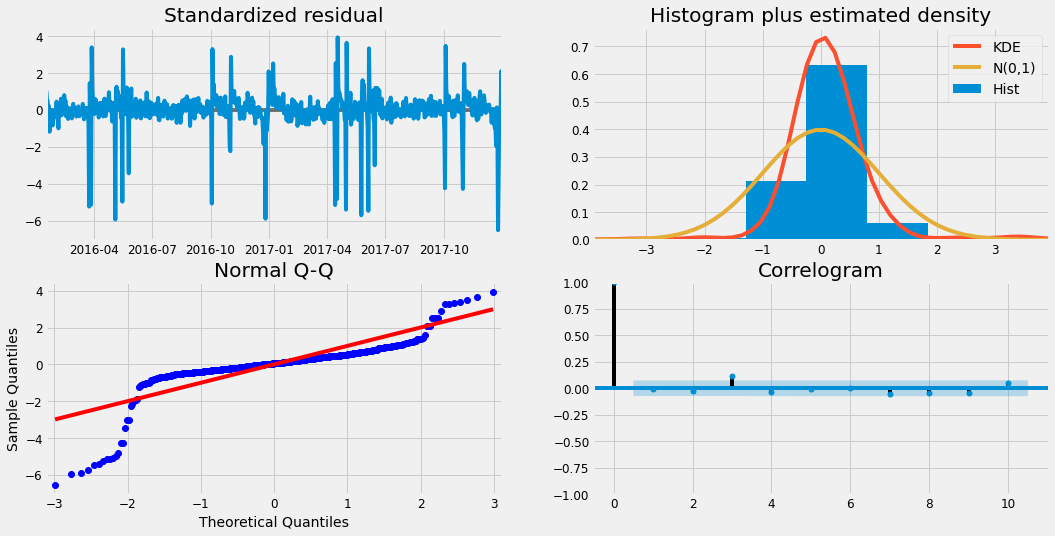

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

 La gráfica Q-Q sugiere claramente que los residuos no se distribuyen normalmente. Los residuos también parecen tener una varianza no constante. Aquí en este punto se debería sugerir una transformación, pero no la vamos a hacer. 

## Validación 

Hagamos algunas previsiones a partir del 01-01-2016 hasta el final de los datos.

In [22]:
consumo['2016'].head()

,Consumption
Date,
2016-01-01,1060.366
2016-01-02,1192.698
2016-01-03,1179.282
2016-01-04,1456.294
2016-01-05,1506.737


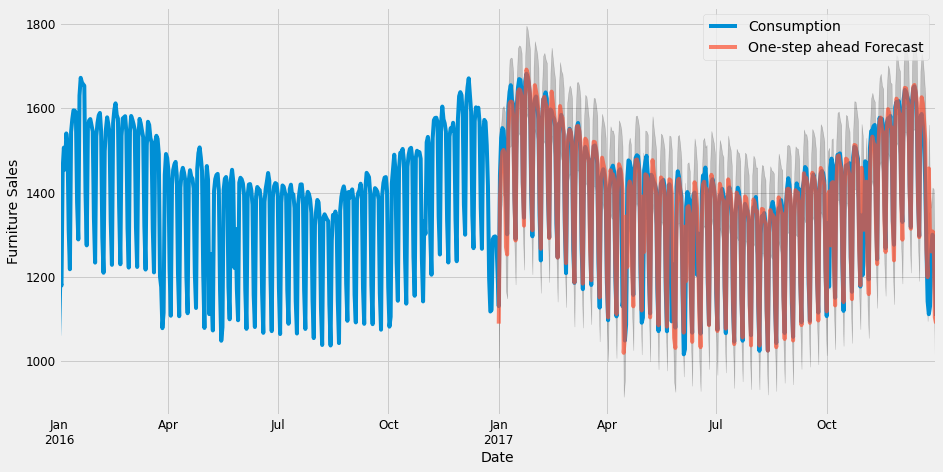

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Pronóstico

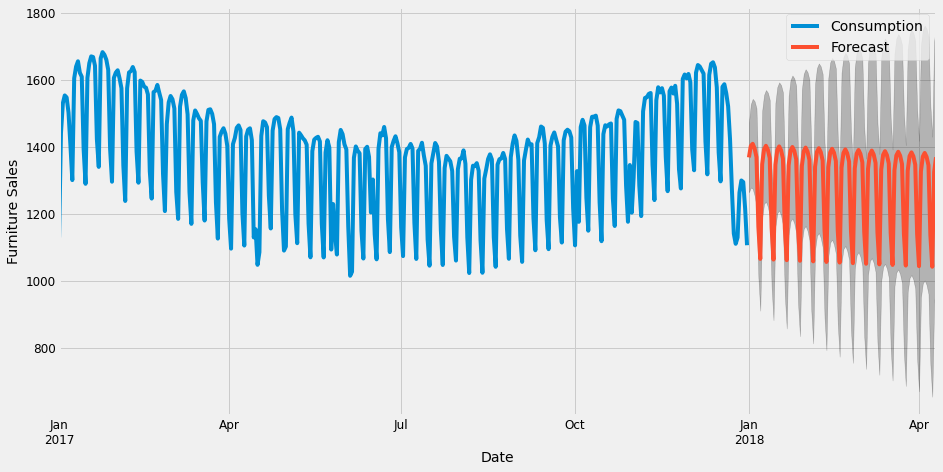

In [25]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = consumo['2017':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Este modelo captura un poco el efecto estacional pero claramente necesita ser mejorado. Como se mencionó anteriormente, nuestros residuales no se distribuyen normalmente y realmente no hemos hecho mucho para seleccionar el mejor modelo posible. Sin embargo, los pasos destacados aquí suelen ser lo que se hará para ajustar los datos de series temporales y predecir el futuro.